In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from google.colab import ai

In [ ]:
DATA_PATH = "drive/MyDrive/eq_5d/eq-5d-200-records.csv"
SAVE_DIR = "drive/MyDrive/eq_5d/eq_5d_soft_stacking"
USE_FEW_SHOT = True

models = [
 "google/gemini-2.5-pro",
 "google/gemma-3-12b",
 "google/gemma-3-27b"
]

In [ ]:
df = pd.read_csv(DATA_PATH)


In [ ]:
def make_zero_shot_prompt(abstract):
    return f"""
You are a biomedical text classification expert.

Task: Determine whether the following clinical study abstract provides **explicit evidence** that the EQ-5D instrument (or a variant like EQ-5D-3L, EQ-5D-5L, EuroQol-5D) was actually **used** in the study's methods or results.

Answer format (exactly one line):
Prediction: [Yes/No]
Confidence: [number between 0 and 100]

Abstract:
\"\"\"{abstract.strip()}\"\"\"
"""

In [ ]:
def make_few_shot_prompt(abstract, examples):
    prompt = """You are a biomedical text classification expert.

Task: Determine whether the following clinical study abstract provides **explicit evidence** that the EQ-5D instrument (or a variant like EQ-5D-3L, EQ-5D-5L, EuroQol-5D) was actually **used** in the study's methods or results.

Answer format (exactly one line):
Prediction: [Yes/No]
Confidence: [number between 0 and 100]

Here are examples:

"""
    for _, ex in examples.iterrows():
        label = "Yes" if ex["Label"] == 1 else "No"
        conf = "90" if ex["Label"] == 1 else "85"
        prompt += f"""Abstract:
\"\"\"{ex['Abstract'].strip()}\"\"\"
Prediction: {label}
Confidence: {conf}

"""
    prompt += f"""\nNow classify this new abstract:

Abstract:
\"\"\"{abstract.strip()}\"\"\""""
    return prompt

def parse_prediction(response):
    pred, conf = "No", 50
    try:
        match_pred = re.search(r"Prediction:\s*(Yes|No)", response, re.I)
        match_conf = re.search(r"Confidence:\s*(\d+)", response)
        if match_pred:
            pred = match_pred.group(1).capitalize()
        if match_conf:
            conf = int(match_conf.group(1))
    except:
        pass
    return pred, conf

In [ ]:
if USE_FEW_SHOT:
    pos_examples = df[df["Label"] == 1].sample(20, random_state=42) # 121
    neg_examples = df[df["Label"] == 0].sample(20, random_state=42) # 79
    few_shot_examples = pd.concat([pos_examples, neg_examples])


In [ ]:
import os

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Created directory: {SAVE_DIR}")
else:
    print(f"Directory already exists: {SAVE_DIR}")

In [ ]:
all_results = []

for model_name in models:
    model_results = []
    print(f"\n Running predictions for {model_name}")

    for idx, row in df.iterrows():
        if USE_FEW_SHOT:
            prompt = make_few_shot_prompt(row["Abstract"], few_shot_examples)
        else:
            prompt = make_zero_shot_prompt(row["Abstract"])

        try:
            response = ai.generate_text(
                prompt=prompt,
                model_name=model_name
            )
            pred, conf = parse_prediction(response)
        except Exception as e:
            print(f"Error with {model_name}, doc {row['No']}: {e}")
            pred, conf = "No", 50

        model_results.append({
            "No": row["No"],
            "True_Label": row["Label"],
            "Prediction": 1 if pred == "Yes" else 0,
            "Confidence": conf
        })

        time.sleep(1.0)

    model_df = pd.DataFrame(model_results)
    model_df.to_csv(f"{SAVE_DIR}/preds_{model_name.replace('/','_')}_pruned_2.csv", index=False)
    all_results.append((model_name, model_df))

In [ ]:
model_weights = {}
model_scores = {}  

for model_name, model_df in all_results:
    print(f"\n Results for {model_name}")
    report = classification_report(model_df["True_Label"], model_df["Prediction"], output_dict=True)
    print(classification_report(model_df["True_Label"], model_df["Prediction"]))
    f1 = report["weighted avg"]["f1-score"]
    model_weights[model_name] = f1
    model_scores[model_name] = f1  

In [ ]:
def weighted_vote(row, model_dfs, model_weights):
    yes_score, no_score = 0, 0
    for model_name, model_df in model_dfs:
        pred = model_df.loc[model_df["No"] == row["No"], "Prediction"].values[0]
        conf = model_df.loc[model_df["No"] == row["No"], "Confidence"].values[0]
        weight = model_weights.get(model_name, 1.0)
        if pred == 1:
            yes_score += weight * (conf / 100)
        else:
            no_score += weight * (conf / 100)
    return 1 if yes_score >= no_score else 0

ensemble_preds = []
for _, row in df.iterrows():
    final_pred = weighted_vote(row, all_results, model_weights)
    ensemble_preds.append({
        "No": row["No"],
        "True_Label": row["Label"],
        "Ensemble_Pred": final_pred
    })

ensemble_df = pd.DataFrame(ensemble_preds)
ensemble_df.to_csv(f"{SAVE_DIR}/ensemble_predictions_pruned.csv", index=False)

print("\n Pruned Ensemble Results")
report_ens = classification_report(ensemble_df["True_Label"], ensemble_df["Ensemble_Pred"], output_dict=True)
print(classification_report(ensemble_df["True_Label"], ensemble_df["Ensemble_Pred"]))
print("Confusion Matrix:")
print(confusion_matrix(ensemble_df["True_Label"], ensemble_df["Ensemble_Pred"]))

model_scores["Pruned_Ensemble"] = report_ens["weighted avg"]["f1-score"]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

print("\n===== STACKING WITH SOFT PROBABILITIES (CV) =====")

features = pd.DataFrame({"No": df["No"], "True_Label": df["Label"]})

for model_name, model_df in all_results:
    probs = []
    for p, c in zip(model_df["Prediction"], model_df["Confidence"]):
        if p == 1:   # Yes
            prob_yes = c / 100
        else:        # No
            prob_yes = 1 - (c / 100)
        probs.append(prob_yes)

    features[f"{model_name}_prob_yes"] = probs
    features[f"{model_name}_conf"] = model_df["Confidence"].values

X = features.drop(columns=["No", "True_Label"])
y = features["True_Label"]

meta_clf = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(meta_clf, X, y, cv=cv)

stacking_soft_results = pd.DataFrame({
    "No": features["No"],
    "True_Label": y,
    "Stacking_Soft_Pred": y_pred
})
stacking_soft_results.to_csv(f"{SAVE_DIR}/stacking_predictions_pruned_soft.csv", index=False)

# Evaluate
print("\n Stacking (Soft Probabilities, 5-fold CV)")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

meta_clf.fit(X, y)
coef = meta_clf.coef_[0]
importance = pd.Series(coef, index=X.columns).sort_values(ascending=False)
print("\n Top 10 Most Influential Features in Soft Stacking Model:")
print(importance.head(10))


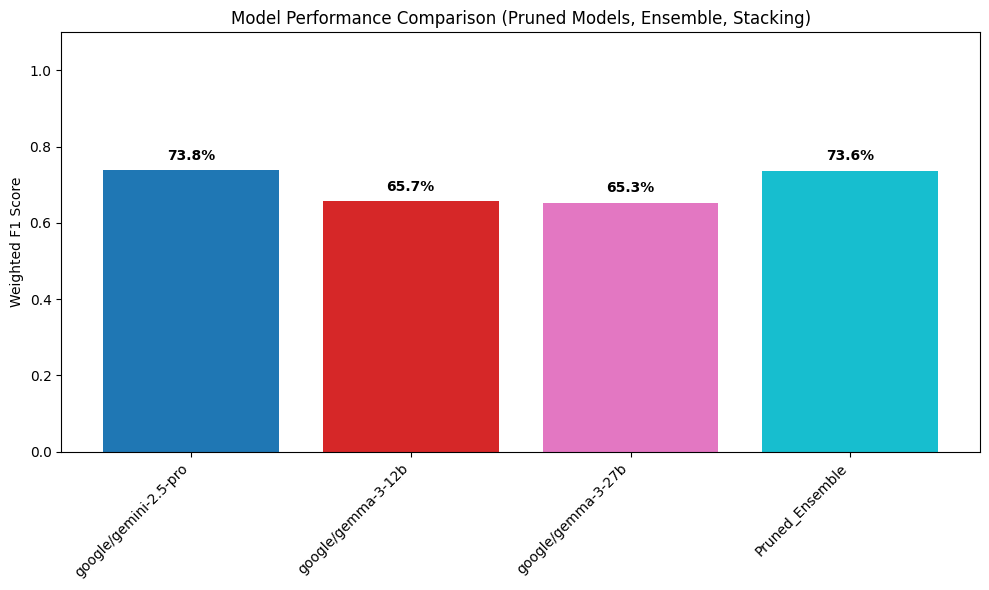

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(model_scores.keys())
values = list(model_scores.values())

colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color=colors)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.02,
             f"{val*100:.1f}%",
             ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.ylabel("Weighted F1 Score")
plt.title("Model Performance Comparison (Pruned Models, Ensemble, Stacking)")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1.1)  #
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/performance_comparison_1.png")
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

df1 = pd.read_csv(f"{SAVE_DIR}/preds_google_gemini-2.5-pro.csv")
df2 = pd.read_csv(f"{SAVE_DIR}/preds_google_gemma-3-12b.csv")
df3 = pd.read_csv(f"{SAVE_DIR}/preds_google_gemma-3-27b.csv")

merged = df1[["No", "True_Label"]].copy()

for i, df in enumerate([df1, df2, df3], start=1):
    merged[f"Prediction_{i}"] = df["Prediction"]
    merged[f"Confidence_{i}"] = df["Confidence"]

final_preds = []

for _, row in merged.iterrows():
    preds = [row["Prediction_1"], row["Prediction_2"], row["Prediction_3"]]
    confs = [row["Confidence_1"], row["Confidence_2"], row["Confidence_3"]]

    counts = pd.Series(preds).value_counts()
    top_count = counts.max()
    majority_classes = counts[counts == top_count].index.tolist()

    if len(majority_classes) == 1:
        final_preds.append(majority_classes[0])
    else:
        best_idx = max(
            range(3),
            key=lambda i: confs[i] if preds[i] in majority_classes else -1
        )
        final_preds.append(preds[best_idx])

merged["Final_Prediction"] = final_preds

merged.to_csv("final_results.csv", index=False)

print(classification_report(merged["True_Label"], merged["Final_Prediction"]))
